# TEST
this a *jupyter notebook* to explain step by step the code.

In [1]:
import json
import sys
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import pymultinest
import corner
from astropy.io import fits
from astropy.table import Table
from scipy.stats import truncnorm
from matplotlib import ticker, cm
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from astropy.convolution import Gaussian2DKernel, convolve, Box2DKernel

## Functions

##### basic functions

In [2]:
def createFolder(folderPath):
	"""create a folder for the path
	"""
	try:
		if not os.path.exists(folderPath):
		    os.mkdir(folderPath)
	except ValueError:
		print("can't create folder - Value error")
	except OSError:
		print("can't create folder - OS error")

##### Standard coord converte and scaled median absolute deviation

In [ ]:
def sMAD(array):
	"""define scaled median absolute deviation
	"""
	return np.median(abs(array-np.median(array)))*1.48

def standardCoords(RA0, DE0, ra, dec, posang, ell):
    """function to transform into standard coords:
    it transforms input (RA,Dec) in standard coordinates
    RA0, DE0, RA, DEC and posang need to be inserted in deg
    
    -INPUTS:
        (RA0,DE0) = central coords for the new ref.system  
        (ra, dec) = coords. to transform
        posang    = glx position angle
        ell       = glx ellipticity
    
    -OUTPUTS:
        xi_out     = standard RA
        xn_out     = standard Dec
        radius_out = elliptical radius
        -->optionals:
        eta_out    = standard x-coord. in the glx ref.syst 
        psi_out    = standard y-coord. in the glx ref.syst
    """
    
    #constants
    pi = 4.*np.arctan(1.)
    degra = pi/180.
    pa = (90.- posang)
    
    #calc. var.
    sd=np.sin(DE0*degra)
    cd=np.cos(DE0*degra)
    tdec=np.tan(dec*degra)
    c=np.cos(ra*degra-RA0*degra)    
    denom=sd*tdec + cd*c
    #find standard coords (xi,xn)
    xi=np.sin(ra*degra-RA0*degra)/denom
    xn=(cd*tdec-sd*c)/denom
    #find standard coords rotated in the 
    #reference system of the galaxy (psi,eta)
    psi_i = xi*np.cos(pa*degra)+xn*np.sin(pa*degra)
    eta_n = (-xi*np.sin(pa*degra)+xn*np.cos(pa*degra))#/(1.-ell)
    
    radius= np.sqrt(psi_i**2+eta_n**2)
    ang   = np.arctan2(eta_n,psi_i)
    
    #out variables
    xi_out= xi*(180./pi)
    xn_out= xn*(180./pi)
    psi_out= psi_i*(180./pi)
    eta_out= eta_n*(180./pi)
    radius_out= radius*(180./pi)
    ang_out= ang*(180./pi)
    return xi_out, xn_out, psi_out, eta_out, radius_out, ang_out

##### probability functions (proper motion)

In [3]:
def LikePM(pmra_syst,pmdec_syst):
	"""Calculate PM likelihood
	"""	

	# variables
	dra  = pmrr - pmra_syst
	ddec = pmdd - pmdec_syst
	
	covrr = sigrr**2 
	covdd = sigdd**2 
	covrd = sigrd*sigrr*sigdd
	
	det = covrr*covdd - covrd**2
	
	Like_PM = (2*np.pi)**(-1) * det**(-0.5) * np.exp(-0.5 * (dra**2*covdd + ddec**2*covrr - 2*dra*ddec*covrd)/det)	
		
	return Like_PM
	
def lnlikePM(cube, ndim, nparams):
	"""Likelihood function
	"""
	# parameters
	meanrr,meandd=cube[0],cube[1]
	frac = cube[2]
	meanV_MW,dispV_MW=cube[3],cube[4]
		
	# Likelihood
	Like_PM = LikePM(meanrr,meandd)
	
	cPlos = (1./np.sqrt(2*np.pi*(evrad**2 + dispV_MW**2)))*np.exp(-0.5*(vrad-meanV_MW)**2/(evrad**2 + dispV_MW**2))
	
	lnLike_i = np.ma.log(frac*(Like_PM*Pcmd*Prad*Plos) + (1.-frac)*(cPpmt*cPcmd*cPrad*cPlos)).filled(-1000.)
	
	return  np.sum(lnLike_i)
	
	
def priorPM(cube, ndim, nparams):
	"""Prior
	"""	
	
	cube[0]=cube[0]*(bPMra-aPMra) + aPMra
	cube[1]=cube[1]*(bPMdec-aPMdec) + aPMdec
	cube[2]=cube[2]*1.
	cube[3]=cube[3]*500. - 250.
	cube[4]=cube[4]*200.

##### Multinest

In [4]:
def runMultinest(parameters, lnlikeMod, priorMod, labels):
	"""---------------------------------------
	Run MultiNest for the input model:
		model=['radial','flat','no']
	-->Input var:
	parameters == list
	ej. parameters = ["vsys","disp","grad","gradPA"]
	"""
	
	# number of dimensions our problem has
	n_params = len(parameters)

	# run MultiNest
	outFolder=dataFolder+'/'+cat
	createFolder(outFolder)
	datafile= outFolder+'/out_'
	
	pymultinest.run(lnlikeMod, priorMod, n_params, outputfiles_basename=datafile, resume = False, verbose = False, sampling_efficiency='model', n_live_points=1000)

	# analyze output
	json.dump(parameters, open(datafile+'params.json', 'w')) # save parameter names
	a = pymultinest.Analyzer(outputfiles_basename=datafile, n_params = n_params)
	
	# get stats
	s = a.get_stats()
	json.dump(s, open(datafile + 'stats.json', 'w'), indent=4)

	bMod=s['global evidence']

	print('MultiNest outputs')
	print('  marginal likelihood:')
	print('    ln Z = %.1f +- %.1f' % (s['global evidence'], s['global evidence error']))
	print('  parameters:')

	medMod=np.array([])
	losMod=np.array([])
	hisMod=np.array([])
	for p, m in zip(parameters, s['marginals']):
		lo, hi = m['1sigma']
		med = m['median']
		medMod=np.append(medMod,med)
		sigma = (hi - lo) / 2.
		losMod=np.append(losMod,lo-med)
		hisMod=np.append(hisMod,hi-med)
		i = max(0, int(-np.floor(np.log10(sigma))) + 1)
		fmt = '%%.%df' % i
		fmts = '\t'.join(['    %-15s' + fmt + " +- " + fmt])
		print(fmts % (p, med, sigma))

	# corner plot
	data=a.get_equal_weighted_posterior()    
	figure = corner.corner(data[:,:-1],labels=labels,quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)))
	plt.savefig(datafile+'marginal.png',dpi=300)
	plt.close()
	
	# get correlation factor between first two parameters
	corrf = (np.sum((data[:,0]-medMod[0])*(data[:,1]-medMod[1])))/(np.sqrt(np.sum((data[:,0]-medMod[0])**2))*np.sqrt(np.sum((data[:,1]-medMod[1])**2)))
	print("Correlation coefficient = {0:3.2f}".format(corrf))	
	
	#-->output: parameters + asym.errors; bayes.evidence
	return medMod,losMod,hisMod,bMod, corrf

##### flux and band correction

In [5]:
def correct_flux_excess_factor(bp_rp, phot_bp_rp_excess_factor):
    """
    Calculate the corrected flux excess factor C* for the input Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    phot_bp_rp_excess_factor: float, numpy.ndarray
        The flux excess factor listed in the Gaia EDR3 archive.
        
    Returns
    -------
    
    The corrected value for the flux excess factor, which is zero for "normal" stars.
    
    Example
    -------
    
    phot_bp_rp_excess_factor_corr = correct_flux_excess_factor(bp_rp, phot_bp_rp_flux_excess_factor)
    """
    
    if np.isscalar(bp_rp) or np.isscalar(phot_bp_rp_excess_factor):
        bp_rp = np.float64(bp_rp)
        phot_bp_rp_excess_factor = np.float64(phot_bp_rp_excess_factor)
    
    if bp_rp.shape != phot_bp_rp_excess_factor.shape:
        raise ValueError('Function parameters must be of the same shape!')
        
    do_not_correct = np.isnan(bp_rp)
    bluerange = np.logical_not(do_not_correct) & (bp_rp < 0.5)
    greenrange = np.logical_not(do_not_correct) & (bp_rp >= 0.5) & (bp_rp < 4.0)
    redrange = np.logical_not(do_not_correct) & (bp_rp > 4.0)
    
    correction = np.zeros_like(bp_rp)
    correction[bluerange] = 1.154360 + 0.033772*bp_rp[bluerange] + 0.032277*np.power(bp_rp[bluerange], 2)
    correction[greenrange] = 1.162004 + 0.011464*bp_rp[greenrange] + 0.049255*np.power(bp_rp[greenrange], 2) \
        - 0.005879*np.power(bp_rp[greenrange], 3)
    correction[redrange] = 1.057572 + 0.140537*bp_rp[redrange]
    
    return phot_bp_rp_excess_factor - correction

def correct_gband(phot_g_mean_mag, bp_rp, astrometric_params_solved):
    """
    Correct the G-band fluxes and magnitudes for the input list of Gaia EDR3 data.
    
    Parameters
    ----------
    
    bp_rp: float, numpy.ndarray
        The (BP-RP) colour listed in the Gaia EDR3 archive.
    astrometric_params_solved: int, numpy.ndarray
        The astrometric solution type listed in the Gaia EDR3 archive.
    phot_g_mean_mag: float, numpy.ndarray
        The G-band magnitude as listed in the Gaia EDR3 archive.
         
    Returns
    -------
    
    The corrected G-band magnitudes and fluxes. The corrections are only applied to
    sources with a 6-parameter astrometric solution fainter than G=13, for which a
    (BP-RP) colour is available.
    
    Example
    -------
    
    gmag_corr = correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag)
    """

    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<=13) | (astrometric_params_solved != 95)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    
    return gmag_corrected
    
def get_EBV(ra,dec,G,BP,RP):
	"""
	Correct G-band magnitudes and BP and RP colors for reddening at specified coords
	"""

	# Transformation of coordinate
	try:
		c_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs')
	except u.UnitTypeError:
		c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
		
	l=c_icrs.galactic.l.degree
	b=c_icrs.galactic.b.degree
	
	# Read the map of Schlegel+98
	ebvlist = fits.open(path+'utils/polecount_dust.fits')
	EBV_map= ebvlist[0].data
	ebvlist.close()
	
	# Calculate reddening
	EBV=np.zeros(len(ra))
	pix_size=0.1 # Degree
	for i in range(0,len(ra)):
		pb=int((b[i]+90.0)/pix_size)
		pl=int((180.0-l[i])/pix_size)
		EBV[i]=0.86*EBV_map[pb,pl] # 0.86=Correction factor from Schlafly+2011

	# Apply correction to mags and colors
	G0  = G  - 2.664*EBV
	BP0 = BP - 3.311*EBV
	RP0 = RP - 2.021*EBV

	return G0, BP0, RP0

def load_mags_cols(ra, dec, phot_g_mean_mag, bp, rp, astrometric_params_solved):
    """
    Load G-band magnitudes and BP_RP colors corrected for G_factor and reddening
    """
    
    # G for the correction factor
    G_corr = correct_gband(phot_g_mean_mag, bp-rp, astrometric_params_solved)
    
    # Dereddened mags and colors
    G0_corr, BP0, RP0 = get_EBV(ra,dec,G_corr, bp, rp)
    
    return G0_corr, BP0, RP0

##### Loading the data from Gaia

In [6]:
def load_GaiaEDR3_table(dataPath, path='', gums=False, **kwarg):

	# Gaia parallax global zero-point [mas]
	ZP_p = -0.017
	
	# Load the actual data		
	t = Table.read(path+dataPath,format='fits')	
	
	# Exclude AGNs from catalog
	agn = Table.read(path+'utils/agns-result.fits',format='fits')
	diff = np.setdiff1d(t['source_id'],agn['source_id'])
	inter,ia,ib=np.intersect1d(t['source_id'].data,diff.data,return_indices=True)
	t = t[ia]
	
	# Quality cuts
	#
	if not gums:
		# account for the color excess factor (Riello+20)
		phot_bp_rp_excess_factor_corr = correct_flux_excess_factor(t['bp_rp'], t['phot_bp_rp_excess_factor'])
		sig_excess_factor_corr = 0.0059898 + 8.817481*10**(-12) * t['phot_g_mean_mag']**(7.618399)
		
		# define parallax difference to select sources consistent with the glx parallax
		parallax_diff = t['parallax'] - ZP_p - kwarg['glxParallax']
		sigParallax = np.sqrt(t['parallax_error']**2 + kwarg['glxParallax_e']**2)
		
		# load reddening-free magnitudes
		t['G0_c'], t['BP0'], t['RP0'] = load_mags_cols(t['ra'], t['dec'], t['phot_g_mean_mag'], t['phot_bp_mean_mag'], \
		t['phot_rp_mean_mag'], t['astrometric_params_solved'])
		# rename columns
		t['G0_c'].description, t['BP0'].description, t['RP0'].description = r'$G_0$', r'$BP_0$', r'$RP_0$'
		
		# perform cuts
		icut = np.where((t['ruwe']<1.4) & (t['astrometric_params_solved']>=31) & (abs(parallax_diff) < 3.*sigParallax) & \
						(abs(phot_bp_rp_excess_factor_corr)< 5*sig_excess_factor_corr) & \
						(t['ipd_frac_multi_peak']<=2.0) & (t['ipd_gof_harmonic_amplitude']<0.2) & \
						(abs(t['pmra'])<5.) & (abs(t['pmdec'])<5.) & ((t['BP0']-t['RP0'])<2.5) & ((t['BP0']-t['RP0'])>-1.0))
	
	else:
		icut = np.where((t['astrometric_params_solved']>=31) & (t['bp_rp']<2.5))	
	
	t = t[icut]
	return t

#### Main function for the probability calculation

##### Build the spatial probability

In [7]:
def st_radius(x,y,theta,ell):
	#central coords.	
	x0 = 0.
	y0 = 0.
	#var
	dx = x-x0
	dy = y-y0
	alfa = theta * (np.pi/180.)

	return np.sqrt((dx*np.cos(alfa)+dy*np.sin(alfa))**2 + (-dx*np.sin(alfa)+dy*np.cos(alfa))**2/(1-ell)**2)

def exp_func(R,R0):
	"""Exponential function
	"""
	return np.exp(-1.68*R/R0)

def my_ceil(a, precision=0):
	return np.round(a + 0.5 * 10**(-precision), precision)

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
	"""Get a truncated normal distribution
	"""
	return truncnorm((low - mean)/sd, (upp - mean)/sd, loc=mean, scale=sd)
        
def exp_prob(xi,xn, PA,PA_e, Ell,Ell_e, R0,R0_e, N=1000, plot=True):
	"""Spatial 2D-lookup map
	"""	
 
	#Get values for N random realizations:
	#
	# PA
	n_theta = np.random.normal(90.-PA,PA_e,N)
	# R0
	X = get_truncated_normal(mean=R0, sd=R0_e, low=0., upp=10.*glxR0)
	n_r0 = X.rvs(N)

	if Ell_e!=0.:	
		# e
		Z = get_truncated_normal(mean=Ell, sd=Ell_e, low=0., upp=0.9)
		n_ell = Z.rvs(N)
	else:
		# e
		n_ell = np.random.normal(Ell,Ell_e,N)	
	
	# define grid
	dummy_x = my_ceil(abs(xi).max(),2)
	dummy_y = my_ceil(abs(xn).max(),2)
	xx = np.linspace(-dummy_x,dummy_x,100)
	yy = np.linspace(-dummy_y,dummy_y,100)
	rr,dd = np.meshgrid(xx,yy)
	xbin = (xx[1:]-xx[:-1])[0]
	ybin = (yy[1:]-yy[:-1])[0]
	
	# calculate exp profile and interpolate over coords. for probs.
	exp_rvp = [exp_func(st_radius(rr,dd,n_theta[i],n_ell[i]),n_r0[i]) for i in range(N)]	
	exp_rvp  = np.array(exp_rvp)
	exp_rvps = np.sum(exp_rvp,axis=0)/(np.sum(exp_rvp)*xbin*ybin)
	
	#interpolate
	points = np.array((rr.flatten(), dd.flatten())).T
	values = exp_rvps.flatten()
	exp_norm = griddata(points, values, (xi,xn))

	#CONTAMINATION
	cnt = 1./(len(xx)*len(yy)*xbin*ybin)
	cnt_norm = np.zeros(len(xi)) + cnt
	
	#PLOT
	if plot:
		#P1
		fig,ax = plt.subplots()
		try:
			lev_exp = np.linspace(np.floor(np.log10(exp_rvps.min())+2.),np.ceil(np.log10(exp_rvps.max())),50)
			levs = np.power(10, lev_exp)
			cs = ax.contourf(rr, dd, exp_rvps, levs, locator=ticker.LogLocator(), cmap=cm.jet)
		except ValueError:	
			cs = ax.contourf(rr, dd, exp_rvps, cmap=cm.viridis)
		ax.add_patch(Ellipse([0,0],2*R0,2*R0*(1-Ell),angle=90.-PA,fill=False,lw=1.0)) 
		ax.add_patch(Ellipse([0,0],2*3*R0,2*3*R0*(1-Ell),angle=90.-PA,fill=False,lw=1.0))  
		cbar = fig.colorbar(cs)
		cbar.ax.set_ylabel('P')
		ax.invert_xaxis()
		ax.set_xlabel(xi.description)
		ax.set_ylabel(xn.description)
		plt.savefig(plotFolder+'/2DLookup_exp.png')
		plt.close()
		
		# P2
		fig,ax = plt.subplots()
		cs = ax.scatter(xi,xn,c=exp_norm)
		cbar = fig.colorbar(cs)
		cbar.ax.set_ylabel('P')
		ax.invert_xaxis()
		ax.set_xlabel(xi.description)
		ax.set_ylabel(xn.description)
		plt.savefig(plotFolder+'/Pexp.png',bbox_inches='tight',dpi=150)
		plt.close()

	return exp_norm, cnt_norm

##### Build the CMD & Proper Motion probability

In [8]:
def line(x,a,b):
	return a*x + b

def completeness(yy, plot=True):
	"""Account for the completeness USING GUMS CATALOG!
	TO IMPROVE catalogs handling
	"""		

	# read the data
	s = load_GaiaEDR3_table('catalogs/'+glx+'_gaiaeDR3.fits', path=path, gums=True)
	
	# load magnitudes
	G, BP, RP = load_mags_cols(s['ra'], s['dec'], s['phot_g_mean_mag'], s['phot_bp_mean_mag'], \
		s['phot_rp_mean_mag'], s['astrometric_params_solved'])
	
	# pass to standard coords
	sXi,sXn,sX,sY,sRad,sAng = standardCoords(glxRA, glxDEC, s['ra'], s['dec'], glxPA, glxEll)
		
	# select contamination
	if glx=='AntliaII':
		icont = np.where((sRad>=3.*glxR0))
	else:	
		icont = np.where((sRad>=5.*glxR0))
	
	# read the gums data
	g = Table.read(path+'catalogs/gums_catalogs/'+glx+'_gums.fits',format='fits')
	G_gums=g['mag_g']
	BP_gums=g['mag_bp']
	RP_gums=g['mag_rp']
	
	igums = np.where((BP_gums-RP_gums)<2.5)
	
	# HISTOGRAMS
	yb=(yy[1:]+yy[:-1])/2
	
	h_obs, bin_edges = np.histogram(G[icont],yy)
	h_gums, bin_edges = np.histogram(G_gums[igums],yy)
	
	frac = ma.masked_invalid(h_obs/h_gums).filled(0)
	
	isel = np.where((yb>17.)&(yb<20.))
	mfrac = np.median(frac[isel])
	
	frac = frac / mfrac
	im = np.argwhere((frac<0.75)&(yb>19.))

	nfrac = np.zeros(len(frac))+1.
	nfrac[im] = frac[im]
	
	if plot:
		fig, ax = plt.subplots()
		ax.bar(bin_edges[:-1], frac, width=np.diff(bin_edges), edgecolor="black", align="edge")
		ax.bar(bin_edges[:-1], nfrac, width=np.diff(bin_edges), fill=False, edgecolor="red", align="edge")
		ax.set_xlabel("G")
		ax.set_ylabel(r"H$_{{obs}}$/H$_{{gums}}$")
		plt.savefig(plotFolder+'/complHist_'+glx+'.png',bbox_inches='tight',dpi=150)
		plt.close()
		
	return nfrac

2D-Histogramms

In [9]:
def synth_hist2D(xx,yy, pathSynth, N=100, compl=True, plot=True, **kvar):
	"""CMD 2D-lookup map using synthetic catalog
	"""	

	#bin size
	xbin = (xx[1:]-xx[:-1])[0]
	ybin = (yy[1:]-yy[:-1])[0]
	
	# read synth. CMD
	st = Table.read(pathSynth,format='fits')
	isel = np.where(st['G']+kvar['DM']-5.*kvar['DM_e'] < 21.5)
	st = st[isel]
	synth_G, synth_BP, synth_RP = st['G'], st['BP'], st['RP']
	
	# linear fit for error coeffs
	poptBP, pcovBP = curve_fit(line, kvar['G'], np.log10(kvar['sigBP']))
	poptRP, pcovRP = curve_fit(line, kvar['G'], np.log10(kvar['sigRP']))

	# draw N random values for DM
	rng = np.random.default_rng(index)
	n_DM = rng.normal(kvar['DM'],kvar['DM_e'],N)
	
	# histogram
	H=[]
	for i in range(N):
				
		# create random G-mags 
		n_G  = synth_G + n_DM[i]
		
		# calculate errors for BP and RP
		s_sigBP = 10**line(n_G,*poptBP)
		s_sigRP = 10**line(n_G,*poptRP)
		
		# create random BP- and RP-mags 
		n_BP = synth_BP+ n_DM[i] + s_sigBP*rng.normal(0,1,len(synth_BP))
		n_RP = synth_RP+ n_DM[i] + s_sigRP*rng.normal(0,1,len(synth_RP))
		
		# calculate the 2D histogram	
		hist, xbins, ybins = np.histogram2d(n_BP-n_RP, n_G, [xx,yy])
		
		H.append(hist)
	
	synth_H0=np.sum(H,axis=0)
	
	# additional smoothing
	synth_H = convolve(synth_H0, Gaussian2DKernel(0.2)) #x_stddev=0.2, y_stddev=0.1
	synth_H[np.isnan(synth_H)] = 0.	

	# correct for completeness
	if compl:
		nfrac = completeness(yy)
		
		#apply to histogram
		xb=(xx[1:]+xx[:-1])/2
		cc,dd = np.meshgrid(xb,nfrac)
		compl_H = synth_H*dd.T
		
		# normalize Hist
		normed_H = compl_H/(np.sum(compl_H)*xbin*ybin)
	
	else:
		# normalize H
		normed_H = synth_H/(np.sum(synth_H)*xbin*ybin)
	
	#PLOT
	if plot:
		plot_hist2D(synth_H,normed_H,**kvar)
		
	return normed_H
	
def hist2D(px,py, xx,yy, kernel_size=3, kernel_type='boxcar', plot=True, **kvar):
	"""2D-histogram
	"""	
	
	# calculate the 2D histogram
	H, xbins, ybins = np.histogram2d(px, py, [xx,yy])
	
	# We smooth with a kernel
	if kernel_type == 'boxcar':
		kernel = Box2DKernel(kernel_size)
	else:
		kernel = Gaussian2DKernel(x_stddev=kernel_size,y_stddev=kernel_size)
		
	# convolve with the kernel to smooth out
	fixed_H0 = convolve(H, kernel)
	fixed_H0[np.isnan(fixed_H0)] = 0.	
	
	# additional Gaussian smoothing
	fixed_H = convolve(fixed_H0, Gaussian2DKernel(0.2))
	fixed_H[np.isnan(fixed_H)] = 0.	
	
	# normalize H
	xbin = (xx[1:]-xx[:-1])[0]
	ybin = (yy[1:]-yy[:-1])[0]

	normed_H = fixed_H/(np.sum(fixed_H)*xbin*ybin)

	#PLOT
	if plot:
		plot_hist2D(H,normed_H,**kvar)
	
	return normed_H

def plot_hist2D(H,norm_H, cnd='', origin='upper',extent=None, ticklabels=False, **kvar):
	"""Plot 2D histograms and lookup-map
	"""

	plt.figure().clf()

	ax1 = plt.subplot(1, 2, 1)
	im = ax1.imshow(H.T, vmin=0.0001, vmax=H.max(), origin=origin,
					interpolation='none', cmap='jet', extent=extent)
	ynan, xnan = np.where(np.isnan(H))
	ax1.set_autoscale_on(False)
	ax1.plot(xnan, ynan, 'rx', markersize=4)
	ax1.set_title("Original")

	ax2 = plt.subplot(1, 2, 2)
	im = ax2.imshow(norm_H.T, vmin=0.0001, vmax=norm_H.max(), origin=origin,
					interpolation='none', cmap='jet', extent=extent)
	ax2.set_title("Normed")
		
	if ticklabels:
		ax1.set_xticklabels([])
		ax1.set_yticklabels([])
		ax2.set_xticklabels([])
		ax2.set_yticklabels([])

	plt.savefig(plotFolder+'/2DHist_'+cnd+'.png',bbox_inches='tight',dpi=150)
	plt.close()

##### lookup-map

In [10]:
def lookup_map(s_px,s_py, H_func, plot=True, **kvar):
	"""2D-likelihood
	"""	
			
	# calculate 2D-histogram
	norm_H = H_func(**kvar)
	
	# define grid
	xb=(kvar['xx'][1:]+kvar['xx'][:-1])/2
	yb=(kvar['yy'][1:]+kvar['yy'][:-1])/2
	pr,pd=np.meshgrid(xb,yb)
	
	# interpolate input data over grid
	points = np.array( (pr.flatten(), pd.flatten()) ).T
	values = norm_H.T.flatten()
	lm_norm = griddata( points, values, (s_px,s_py) )
	
	# mask NaN values
	lm_norm = np.ma.masked_invalid(lm_norm).filled(0) 
	
	#PLOT
	if plot:		
		#P1
		fig,ax = plt.subplots()
		cs = ax.contourf(pr,pd, norm_H.T)
		cbar = fig.colorbar(cs)
		cbar.ax.set_ylabel('P')
		if kvar['cnd'].find('cmd') != -1:
			ax.invert_yaxis()
		ax.set_xlabel(s_px.description)
		ax.set_ylabel(s_py.description)
		plt.savefig(plotFolder+'/2DLookup_'+kvar['cnd']+'.png', bbox_inches='tight', dpi=150)
		plt.close()		
		#P2
		fig,ax = plt.subplots()
		cs = ax.scatter(s_px,s_py,c=lm_norm)
		cbar = fig.colorbar(cs)
		cbar.ax.set_ylabel('P')
		if kvar['cnd'].find('cmd') != -1:
			ax.invert_yaxis()
		ax.set_xlabel(s_px.description)
		ax.set_ylabel(s_py.description)
		plt.savefig(plotFolder+'/P'+kvar['cnd']+'.png', bbox_inches='tight', dpi=150)
		plt.close()
		
	return lm_norm

## Test galaxy - Sextans
now let's visualize the data to help us understand the code

In [11]:
path = '../Data/'
dataPath = 'sextans/'

dat = Table.read(path+dataPath+'Sextans_r4deg_gaiaeDR3.fits', format='fits')
glx_head = dat.to_pandas()

glx_head.head(15)

,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,...,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,l,b,ruwe,ipd_gof_harmonic_amplitude,ipd_frac_multi_peak
0,3831849738500990976,152.368011,0.041581,0.354323,0.046224,1.038120,0.047829,21.704788,-3.810006,0.053991,...,19.514326,353.574799,15.150808,1.221014,1.123211,240.657136,42.815923,1.080303,0.095006,0
1,3831849802925752576,152.351279,0.171911,0.361654,0.185660,0.538223,0.180899,2.975271,-2.682987,0.216038,...,7.867318,69.066795,17.910156,1.220675,1.068167,240.635217,42.807256,0.984437,0.102124,0
2,3831849871645234176,152.387226,0.518873,0.374752,0.672582,0.125768,0.522182,0.240850,11.804439,0.618566,...,15.938340,12.281301,19.018677,1.262245,1.209951,240.651326,42.843644,1.079229,0.102935,0
3,3831849906004970368,152.374594,0.420389,0.369681,0.556130,1.245294,0.430746,2.891016,5.831565,0.512055,...,12.430202,25.778782,18.483543,1.458863,2.351456,240.646166,42.830568,1.021391,0.171424,0
4,3831849906004974080,152.371298,0.500013,0.379866,0.688989,0.281820,0.481094,0.585789,-9.010223,0.617266,...,10.953891,20.878216,18.849741,1.467691,2.039112,240.632455,42.834242,0.971610,0.089361,0
5,3831849940364711936,152.382119,0.052960,0.377579,0.063120,2.888572,0.058829,49.100739,-23.972424,0.066618,...,20.420101,273.781250,15.379242,1.334397,2.003370,240.643999,42.841361,0.949355,0.066024,0
6,3831850009084187392,152.342741,0.091765,0.373790,0.101839,0.287062,0.093543,3.068774,-14.666369,0.119907,...,10.099731,127.675529,16.971851,1.196504,0.842209,240.615017,42.807997,1.032854,0.175755,0
7,3831850077803667200,152.342770,0.091691,0.384771,0.103423,0.646215,0.096069,6.726601,-2.444242,0.114841,...,11.079157,136.793274,16.796467,1.223051,1.304050,240.603243,42.814779,1.002306,0.138030,0
8,3831850455760793472,152.412872,0.097575,0.402224,0.120873,0.449576,0.103745,4.333457,-5.982448,0.121185,...,17.498461,70.178864,17.024879,1.203025,0.970091,240.643341,42.880767,1.021587,0.097319,0
9,3831850455760794752,152.413293,0.069063,0.405799,0.083075,1.155663,0.074750,15.460385,0.000885,0.086505,...,13.296795,196.081055,16.207439,1.248851,1.397385,240.639851,42.883300,1.004345,0.082106,0


let's now run the _MAIN CODE_ part for a single test galaxy

In [12]:
# read the master table with glx info
mt = Table.read(path+'utils/master_table_edr3_final.txt',format='ascii')
it = np.where((mt['name']=='Sextans'))
mt = mt[it]

#print(mt)
glx=mt['name'][0]
print('Galaxy: {0}'.format(glx))

cat='spec_'+glx

#define galaxy main parameters
# Type
glxType = mt['type'][0]
# central coords [deg]
glxRA  = mt['ra'][0]
glxDEC = mt['dec'][0]
# position angle [deg] and ellipticity	
if mt['PA'][0] > 9000 or mt['ePA_plus'][0] > 9000 or mt['ePA_minus'][0] > 9000 or \
mt['ellip'][0] > 9000 or mt['e_ellip_plus'][0] > 9000 or mt['e_ellip_minus'][0] > 9000:	
	glxPA   = 0.
	glxPA_e = 0.
	glxEll   = 0.
	glxEll_e = 0.		
else:
	glxPA   = mt['PA'][0] 
	glxPA_e = (mt['ePA_plus'][0]+mt['ePA_minus'][0])/2.		
	glxEll   = mt['ellip'][0] 	
	glxEll_e = (mt['e_ellip_plus'][0]+mt['e_ellip_minus'][0])/2.
# half-light radius [deg]
glxR0   = mt['rh'][0]/60.
glxR0_e = (mt['erh_plus'][0]+mt['erh_minus'][0])/2./60.
# distance modulus
glxDM   = mt['dm'][0]
glxDM_e = (mt['edm_plus'][0]+mt['edm_minus'][0])/2.
#-->systemic parallax [mas]
glxParallax = 10.**(-(glxDM+5.)/5.)*10.**3 
glxParallax_e = abs(-0.2*np.log(10)*glxParallax*glxDM_e)

print('Galaxy parameters:')
print('  Type: {0}'.format(glxType))
print('  RA: {0:3.5f} deg'.format(glxRA))
print('  DEC: {0:3.5f} deg'.format(glxDEC))
print('  PA: {0:3.2f} deg'.format(glxPA))
print('  Ell: {0:3.2f}'.format(glxEll))
print('  R0: {0:3.2f} deg'.format(glxR0))
print('  DM: {0:3.5f} Mpc'.format(glxDM))
print('  Parallax: {0:3.5f} mas'.format(glxParallax))

Galaxy: Sextans
Galaxy parameters:
  Type: dSph
  RA: 153.26800 deg
  DEC: -1.61800 deg
  PA: 52.00 deg
  Ell: 0.27
  R0: 0.36 deg
  DM: 19.64000 Mpc
  Parallax: 0.01180 mas


by loading the table we did all the cut in sec. 3 of the paper

In [13]:
# load table
t = load_GaiaEDR3_table(dataPath=dataPath, path=path, file='Sextans_r4deg_gaiaeDR3.fits', glxParallax=glxParallax, glxParallax_e=glxParallax_e)	

we prepare the spatial coord. data for the proper motion 

In [14]:
# Mags & color
# G-band magnitudes and BP_RP colors corrected for G_factor and reddening
G, BP, RP = t['G0_c'], t['BP0'], t['RP0']
G_col = BP-RP
# define errors
sigG  = 1.086/t['phot_g_mean_flux_over_error']
sigBP = 1.086/t['phot_bp_mean_flux_over_error']
sigRP = 1.086/t['phot_rp_mean_flux_over_error']
sigG_col = np.sqrt(sigBP**2+sigRP**2)
# rename columns
G_col.name = 'BP0-RP0'
G_col.description = r'$(BP-RP)_0$'
		
# Spatial coordinates
# pass to standard coords
tXi,tXn,tX,tY,tRad,tAng = standardCoords(glxRA, glxDEC, t['ra'], t['dec'], glxPA, glxEll)
# rename columns
tXi.name, tXn.name, tRad.name = 'xi', 'xn', 'radius'
tXi.description, tXn.description, tRad.description = r'$\Delta \alpha$ [deg]', r'$\Delta \delta$ [deg]', 'Ell. Radius [deg]'
		
# Proper motion values
# define PM variables
pmra    = t['pmra']
pmdec   = t['pmdec']
epmra   = t['pmra_error']
epmdec  = t['pmdec_error']
epmcorr = t['pmra_pmdec_corr']
# rename columns
pmra.name, pmdec.name = 'pmra', 'pmdec'
pmra.description, pmdec.description = r'$\mu_{\rm \alpha*}$ [mas yr$^{-1}$]', r'$\mu_{\rm \delta}$ [mas yr$^{-1}$]'
		
# define PM prior limits
aPMra = -5.
bPMra = 10.
aPMdec = -5
bPMdec = 10.

we check the plot for the visual determination

Length of sample = 139774
Length of contamination = 111068


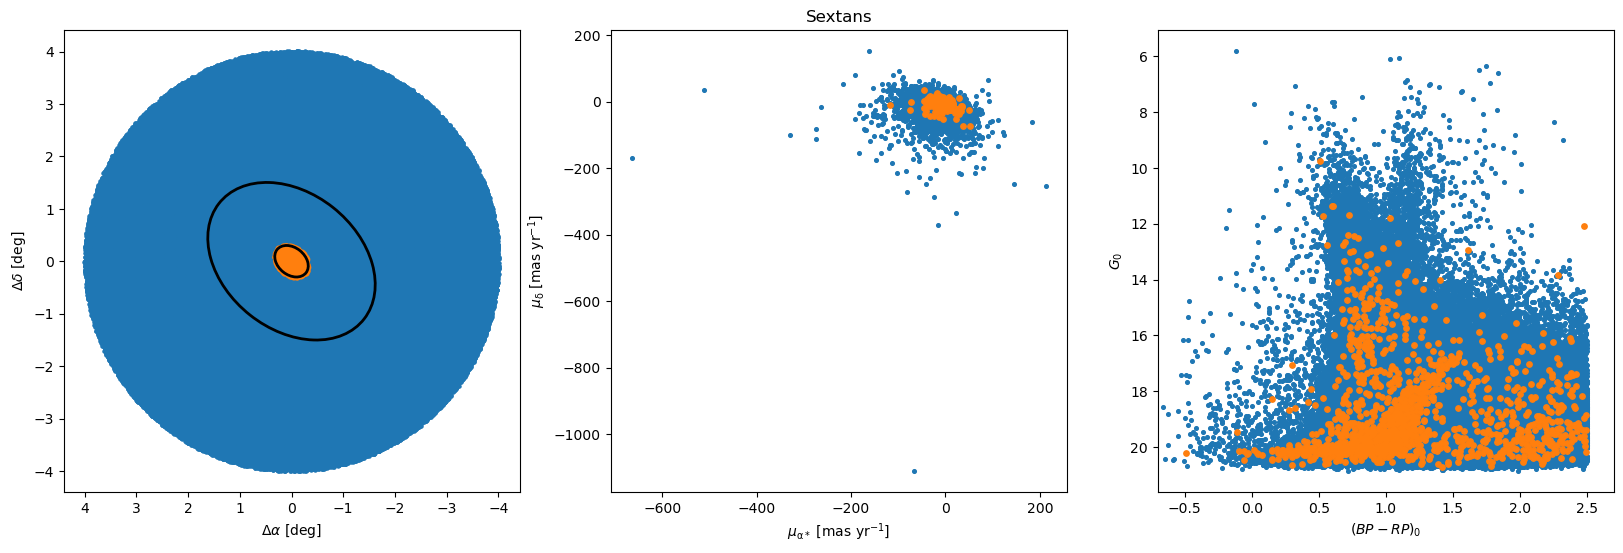

In [15]:
# select inner glx
iz = np.where((st_radius(tXi,tXn,90.-glxPA,glxEll)<=1.*glxR0))
		
# select glx sample
if glxType == 'dSph':						# glxR0 half light radius in degrees
	ix = np.where((tRad>=0.*glxR0))         # Here we select all the sample since it's a dSph? -> GALAXY + CONTAMINATION
elif glxType == 'UFD' and 5.*glxR0 < 0.25:
	ix = np.where((tRad<=0.25)) 
else:
	ix = np.where((tRad<=5.*glxR0)) 

# select contamination
if glx=='AntliaII':
	iy = np.where((tRad>3.*glxR0)) 
elif glx=='BootesIII':
	iy = np.where((tRad>4.*glxR0)&(tRad<6.5*glxR0)) 
else:
	iy = np.where((tRad>5.*glxR0)) 
					
print('Length of sample = {0}'.format(len(tXi[ix])))
print('Length of contamination = {0}'.format(len(tXi[iy])))

# Output folders
cataFolder = path+dataPath+'out_cat'
createFolder(cataFolder)
dataFolder = path+dataPath+'kin_'+cat
createFolder(dataFolder)
plotFolder = path+dataFolder+'/plots'
createFolder(plotFolder)

# check plots
plot = True
if plot:
									
	fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 6))
	#P1
	ax1.scatter(tXi[iy],tXn[iy],s=1,c='gray')
	ax1.scatter(tXi[ix],tXn[ix],s=5) #color blue -> GALAXY + CONTAMINATION
	ax1.scatter(tXi[iz],tXn[iz],s=10) #color orage
	ax1.invert_xaxis()
	#Here I consider the 2* since in input wants the diameter
	ax1.add_patch(Ellipse([0,0],2*glxR0,2*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0)) 
	ax1.add_patch(Ellipse([0,0],2*5*glxR0,2*5*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0)) 
	#ax1.add_patch(Ellipse([0,0],2*10*glxR0,2*10*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0))  
	ax1.set_xlabel(tXi.description)
	ax1.set_ylabel(tXn.description)
	#P2
	ax2.scatter(pmra[iy],pmdec[iy],s=1,c='gray')
	ax2.scatter(pmra[ix],pmdec[ix],s=7) #color blue
	ax2.scatter(pmra[iz],pmdec[iz],s=15) #color orage
	ax2.set_xlabel(pmra.description)
	ax2.set_ylabel(pmdec.description)
	ax2.set_title(glx)
	#P3
	ax3.scatter(G_col[iy], G[iy],s=1,c='gray')
	ax3.scatter(G_col[ix], G[ix],s=7)
	ax3.scatter(G_col[iz], G[iz],s=15)
	ax3.invert_yaxis()
	ax3.set_xlim(-0.7,2.7)
	ax3.set_xlabel(G_col.description)
	ax3.set_ylabel(G.description)
	fig.savefig(plotFolder+'/'+glx+'_check_plot.jpeg', bbox_inches='tight', dpi=150)

### Build 2D-lookup probabilities

#### Spatial probability

In [16]:
# GALAXY + CONTAMINATION
Prad, cPrad = exp_prob(tXi[ix],tXn[ix], glxPA,glxPA_e, glxEll,glxEll_e, glxR0,glxR0_e)	
				
#################
# CMD probability
		
# create a grid for the histogram
xx=np.arange(-0.7,2.6,0.05)
yy=np.arange(13.1,21.2,0.20)
		
#GALAXY
if glxType=='dSph':
	Pcmd = lookup_map(G_col[ix],G[ix], hist2D, xx=xx,yy=yy, px=G_col[iz],py=G[iz], \
			cnd='cmd_glx',extent=[xx[0],xx[-1],yy[-1],yy[0]])
elif glxType=='UFD':
	Pcmd = lookup_map(G_col[ix],G[ix], synth_hist2D, xx=xx,yy=yy,DM=glxDM,DM_e=glxDM_e, G=G, sigBP=sigBP, sigRP=sigRP, \
			pathSynth=path+'utils/synth_ufd_eGDR3.fits', cnd='cmd_synth_glx',extent=[xx[0],xx[-1],yy[-1],yy[0]], \
			path=path)

#CONTAMINATION	
cPcmd = lookup_map(G_col[ix],G[ix], hist2D, xx=xx,yy=yy, px=G_col[iy],py=G[iy], \
		cnd='cmd_cnt',extent=[xx[0],xx[-1],yy[-1],yy[0]])


#### Proper Motion probability

In [17]:
# create a grid with bivariate values
xx=np.arange(-5.4,5.4,0.2)
yy=np.arange(-5.4,5.4,0.2)
			
#CONTAMINATION
cPpmt = lookup_map(pmra[ix],pmdec[ix], hist2D, xx=xx,yy=yy, px=pmra[iy],py=pmdec[iy], kernel_size=5,\
		cnd='pm_cnt',origin='lower',extent=[xx[0],xx[-1],yy[0],yy[-1]])		


#### Multinest

In [ ]:
#set variables
if glx=='AntliaII' or glx=='BootesIII' or glx=='CraterI':
	pmrr  = pmra[ix].data
	pmdd  = pmdec[ix].data
	sigrr = epmra[ix].data
	sigdd = epmdec[ix].data
	sigrd = epmcorr[ix].data
else:
	pmrr  = pmra[ix].data
	pmdd  = pmdec[ix].data
	sigrr = epmra[ix].data
	sigdd = epmdec[ix].data
	sigrd = epmcorr[ix].data	

"""
print(np.ma.median(pmrr),np.ma.median(pmdd))
print(np.where(Pcmd==0.))
print(np.where(cPcmd==0.))		
print(np.where(cPpmt==0.))
"""	
		
#-------------------------------------	
# number of dimensions our problem has
parameters = ["pmra","pmdec","frac"]
labels     = [r"${PM}_{\rm RA}$",r"${PM}_{\rm DEC}$","q"]
# run the MultiNest
med,los,his,bZ,corrF = runMultinest(parameters, lnlikePM, priorPM, labels)
		
# save the outputs
total=[med,los,his,bZ,corrF]
		
outMod=[]
for dum in total:
	outMod=np.append(outMod,dum)
		
np.savetxt(dataFolder+'/kin_'+cat+'.txt',outMod.reshape(1, outMod.shape[0]),fmt='%7.3f', \
header=('PM_RA\tPM_DEC\tQ\tePM_RA_d\tePM_DEC_d\teQ_d\tePM_RA_u\tePM_DEC_u\teQ_u\tlnZ\tC'))
		

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    3
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging toward

Exception ignored on calling ctypes callback function: <function run.<locals>.loglike at 0x7f785b22bbe0>
Traceback (most recent call last):
  File "/home/marcoboscato/miniconda3/envs/Tesi/lib/python3.10/site-packages/pymultinest/run.py", line 228, in loglike
    return LogLikelihood(cube, ndim, nparams)
  File "/tmp/ipykernel_11460/1933682249.py", line 27, in lnlikePM
  File "/tmp/ipykernel_11460/1933682249.py", line 15, in LikePM
KeyboardInterrupt: 



 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.
 Parameter            2  of mode            1  is converging towards the edge of the prior.


set output probabilities

In [19]:
# set output probabilities
Like_PM = LikePM(outMod[0],outMod[1])
		
P_i = outMod[2]*(Like_PM*Pcmd*Prad)/(outMod[2]*(Like_PM*Pcmd*Prad) + (1.-outMod[2])*(cPrad*cPcmd*cPpmt))
		
print(len(P_i[np.where(P_i>0.95)]))
			
# obtain tangential velocity
o_pmra  = outMod[0]
o_pmdec = outMod[1]
o_epmra  = (outMod[6]-outMod[3])/2.
o_epmdec = (outMod[7]-outMod[4])/2.

pmtan = np.sqrt(o_pmra**2+o_pmdec**2)
epmtan = np.sqrt(o_epmra**2*o_pmra**2/pmtan**2 + o_epmdec**2*o_pmdec**2/pmtan**2)

vtan = 4.74*pmtan/glxParallax
evtan = abs(vtan)*np.ma.sqrt((epmtan/pmtan)**2 + (glxParallax_e/glxParallax)**2)
print("VTAN = {0:3.2f} +- {1:3.2f}".format(vtan,evtan))
		
# pmdist = np.sqrt(dra**2 + ddec**2) / np.sqrt( covrr + covdd + 2*0.035**2 + ((outMod[6]-outMod[3])/2.)**2 + ((outMod[7]-outMod[4])/2.)**2) 


1133
VTAN = 162.55 +- 3.26


/tmp/ipykernel_248991/1135256678.py:4: RuntimeWarning: invalid value encountered in divide
  P_i = outMod[2]*(Like_PM*Pcmd*Prad)/(outMod[2]*(Like_PM*Pcmd*Prad) + (1.-outMod[2])*(cPrad*cPcmd*cPpmt))


#### Plots

In [20]:
# save output values
s = t[ix]
s['Xi'] = tXi[ix]
s['Xn'] = tXn[ix]
s['Rad'] = tRad[ix]
s['P'] = P_i
s.write(cataFolder+'/out_'+cat+'_eDR3.fits', format='fits',overwrite=True)  

#PLOT
ipu = np.where(P_i>=0.5)
ipd = np.where(P_i<0.5)
# fontsize
fsize = 14
		
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 6))
#P1
ax1.scatter(tXi[ix][ipd],tXn[ix][ipd],s=1,c='gray')
ax1.scatter(tXi[ix][ipu],tXn[ix][ipu],s=25,c=P_i[ipu],cmap='jet')
ax1.invert_xaxis()
ax1.add_patch(Ellipse([0,0],2*glxR0,2*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0)) 
ax1.add_patch(Ellipse([0,0],2*3*glxR0,2*3*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0))  
ax1.set_xlabel(tXi.description,fontsize=fsize+2)
ax1.set_ylabel(tXn.description,fontsize=fsize+2)
ax1.tick_params(axis='x', labelsize=fsize) 
ax1.tick_params(axis='y', labelsize=fsize) 
#P2
ax2.scatter(pmra[ix][ipd],pmdec[ix][ipd],s=1,c='gray')
cs = ax2.scatter(pmra[ix][ipu],pmdec[ix][ipu],s=25,c=P_i[ipu],cmap='jet')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('P',fontsize=fsize+2)
cbar.ax.tick_params(axis='y', labelsize=fsize) 
ax2.set_xlabel(pmra.description,fontsize=fsize+2)
ax2.set_ylabel(pmdec.description,fontsize=fsize+2)
ax2.tick_params(axis='x', labelsize=fsize) 
ax2.tick_params(axis='y', labelsize=fsize) 
#P3
ax3.scatter(G_col[ix][ipd],G[ix][ipd],s=1,c='gray')
ax3.scatter(G_col[ix][ipu],G[ix][ipu],s=25,c=P_i[ipu],cmap='jet')
ax3.invert_yaxis()
ax3.set_xlim(-0.7,2.7)
ax3.set_xlabel(G_col.description,fontsize=fsize+2)
ax3.set_ylabel(G.description,fontsize=fsize+2)
ax3.tick_params(axis='x', labelsize=fsize) 
ax3.tick_params(axis='y', labelsize=fsize) 
		
fig.savefig(plotFolder+'/'+glx+'_out_P.jpeg', bbox_inches='tight', dpi=150)

plt.close('all')
		
if mt['type'][0]=='UFD':
	xx=np.arange(-0.6,2.6,0.05)
	yy=np.arange(13.1,21.2,0.20)
	xb=(xx[1:]+xx[:-1])/2
	yb=(yy[1:]+yy[:-1])/2
	pr,pd=np.meshgrid(xb,yb)
			
	normed_H=synth_hist2D(xx=xx,yy=yy,DM=glxDM,DM_e=glxDM_e, G=G, sigBP=sigBP, sigRP=sigRP, plot=False, pathSynth=path+'utils/synth_ufd_eGDR3.fits',path=path)
			
	ic=P_i>0.5
	fig,ax = plt.subplots()
	ax.contour(pr,pd, normed_H.T)
	cs = ax.scatter(G_col[ix][ic],G[ix][ic],s=10*(P_i[ic]+0.1),c=P_i[ic],cmap='jet')
	cbar = fig.colorbar(cs)
	cbar.ax.set_ylabel('P')
	ax.invert_yaxis()
	fig.savefig(plotFolder+'/'+glx+'_out_Pcmd.jpeg', bbox_inches='tight', dpi=150)

	plt.close()

### (Original main code)

In [21]:
'''
if __name__ == "__main__":
		
	# PATHS

	"""original path:
	path = '/home7floyd/Work/Projects/gaia/eGDR3/'
	dataPath = path+'bayes_analysis/eDR3/'
	"""
	
	path = '../Data/'
	dataPath = 'sextans/1727791070462O-result.fits'
	
	# read the master table with glx info
	mt = Table.read(path+'utils/master_table_edr3_final.txt',format='ascii')
	it = np.where((mt['type']=='UFD'))#|(mt['type']=='dSph'))
	mt = mt[it]
	
	listGlx=mt['name'].data
	
	for index in np.arange(5,len(listGlx),1):#np.arange(0,len(listGlx),1):
		
		glx = listGlx[index]
		print('Galaxy: {0}'.format(glx))
		
		cat='test_'+glx
		
		#define galaxy main parameters
		# Type
		glxType = mt['type'][index]
		# central coords [deg]
		glxRA  = mt['ra'][index]
		glxDEC = mt['dec'][index] 
		# position angle [deg] and ellipticity
		if mt['PA'][index] > 9000 or mt['ePA_plus'][index] > 9000 or mt['ePA_minus'][index] > 9000 or \
		mt['ellip'][index] > 9000 or mt['e_ellip_plus'][index] > 9000 or mt['e_ellip_minus'][index] > 9000:	
			glxPA   = 0.
			glxPA_e = 0.
			glxEll   = 0.
			glxEll_e = 0.		
		else:
			glxPA   = mt['PA'][index] 
			glxPA_e = (mt['ePA_plus'][index]+mt['ePA_minus'][index])/2.		
			glxEll   = mt['ellip'][index] 	
			glxEll_e = (mt['e_ellip_plus'][index]+mt['e_ellip_minus'][index])/2.
		# half-light radius [deg]
		glxR0   = mt['rh'][index]/60.
		glxR0_e = (mt['erh_plus'][index]+mt['erh_minus'][index])/2./60.
		# distance modulus
		glxDM   = mt['dm'][index]
		glxDM_e = (mt['edm_plus'][index]+mt['edm_minus'][index])/2.
		#-->systemic parallax [mas]
		glxParallax = 10.**(-(glxDM+5.)/5.)*10.**3 
		glxParallax_e = abs(-0.2*np.log(10)*glxParallax*glxDM_e)
		
		# load table
		t = load_GaiaEDR3_table('catalogs/'+glx+'_gaiaeDR3.fits', path=path, glxParallax=glxParallax, glxParallax_e=glxParallax_e)		
		
		# Mags & color
		# G-band magnitudes and BP_RP colors corrected for G_factor and reddening
		G, BP, RP = t['G0_c'], t['BP0'], t['RP0']
		G_col = BP-RP
		# define errors
		sigG  = 1.086/t['phot_g_mean_flux_over_error']
		sigBP = 1.086/t['phot_bp_mean_flux_over_error']
		sigRP = 1.086/t['phot_rp_mean_flux_over_error']
		sigG_col = np.sqrt(sigBP**2+sigRP**2)
		# rename columns
		G_col.name = 'BP0-RP0'
		G_col.description = r'$(BP-RP)_0$'
		
		# Spatial coordinates
		# pass to standard coords
		tXi,tXn,tX,tY,tRad,tAng = standardCoords(glxRA, glxDEC, t['ra'], t['dec'], glxPA, glxEll)
		# rename columns
		tXi.name, tXn.name, tRad.name = 'xi', 'xn', 'radius'
		tXi.description, tXn.description, tRad.description = r'$\Delta \alpha$ [deg]', r'$\Delta \delta$ [deg]', 'Ell. Radius [deg]'
		
		# Proper motion values
		# define PM variables
		pmra    = t['pmra']
		pmdec   = t['pmdec']
		epmra   = t['pmra_error']
		epmdec  = t['pmdec_error']
		epmcorr = t['pmra_pmdec_corr']
		# rename columns
		pmra.name, pmdec.name = 'pmra', 'pmdec'
		pmra.description, pmdec.description = r'$\mu_{\rm \alpha*}$ [mas yr$^{-1}$]', r'$\mu_{\rm \delta}$ [mas yr$^{-1}$]'
		
		# define PM prior limits
		aPMra = -5.
		bPMra = 10.
		aPMdec = -5
		bPMdec = 10.
		
		##############
		# SELECTIONS #
		##############
		
		# select inner glx
		iz = np.where((st_radius(tXi,tXn,90.-glxPA,glxEll)<=1.*glxR0))
		
		# select glx sample
		if glxType == 'dSph':
			ix = np.where((tRad>=0.*glxR0))
		elif glxType == 'UFD' and 5.*glxR0 < 0.25:
		    ix = np.where((tRad<=0.25)) 
		else:
		    ix = np.where((tRad<=5.*glxR0)) 

		# select contamination
		if glx=='AntliaII':
			iy = np.where((tRad>3.*glxR0)) 
		elif glx=='BootesIII':
			iy = np.where((tRad>4.*glxR0)&(tRad<6.5*glxR0)) 
		else:
			iy = np.where((tRad>5.*glxR0)) 
					
		print('Length of sample = {0}'.format(len(tXi[ix])))
		print('Length of contamination = {0}'.format(len(tXi[iy])))

		# Output folders
		cataFolder = dataPath+'out_cat'
		createFolder(cataFolder)
		dataFolder = dataPath+'kin_'+cat
		createFolder(dataFolder)
		plotFolder = dataFolder+'/plots'
		createFolder(plotFolder)

		# check plots
		plot = True
		if plot:
									
			fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 6))
			#P1
			ax1.scatter(tXi[iy],tXn[iy],s=1,c='gray')
			ax1.scatter(tXi[ix],tXn[ix],s=5)
			ax1.scatter(tXi[iz],tXn[iz],s=10)
			ax1.invert_xaxis()
			ax1.add_patch(Ellipse([0,0],2*glxR0,2*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0)) 
			ax1.add_patch(Ellipse([0,0],2*5*glxR0,2*5*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0)) 
			#ax1.add_patch(Ellipse([0,0],2*10*glxR0,2*10*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0))  
			ax1.set_xlabel(tXi.description)
			ax1.set_ylabel(tXn.description)
			#P2
			ax2.scatter(pmra[iy],pmdec[iy],s=1,c='gray')
			ax2.scatter(pmra[ix],pmdec[ix],s=7)
			ax2.scatter(pmra[iz],pmdec[iz],s=15)
			ax2.set_xlabel(pmra.description)
			ax2.set_ylabel(pmdec.description)
			ax2.set_title(glx)
			#P3
			ax3.scatter(G_col[iy], G[iy],s=1,c='gray')
			ax3.scatter(G_col[ix], G[ix],s=7)
			ax3.scatter(G_col[iz], G[iz],s=15)
			ax3.invert_yaxis()
			ax3.set_xlim(-0.7,2.7)
			ax3.set_xlabel(G_col.description)
			ax3.set_ylabel(G.description)
			fig.savefig(plotFolder+'/'+glx+'_check_plot.jpeg', bbox_inches='tight', dpi=150)
								
	
		##############################
		#Build 2D-lookup probabilities
		##############################
		
		#####################
		# Spatial probability
		
		# GALAXY + CONTAMINATION
		Prad, cPrad = exp_prob(tXi[ix],tXn[ix], glxPA,glxPA_e, glxEll,glxEll_e, glxR0,glxR0_e)	
				
		#################
		# CMD probability
		
		# create a grid for the histogram
		xx=np.arange(-0.7,2.6,0.05)
		yy=np.arange(13.1,21.2,0.20)
		
		#GALAXY
		if glxType=='dSph':
			Pcmd = lookup_map(G_col[ix],G[ix], hist2D, xx=xx,yy=yy, px=G_col[iz],py=G[iz], \
					cnd='cmd_glx',extent=[xx[0],xx[-1],yy[-1],yy[0]])
		elif glxType=='UFD':
			Pcmd = lookup_map(G_col[ix],G[ix], synth_hist2D, xx=xx,yy=yy,DM=glxDM,DM_e=glxDM_e, G=G, sigBP=sigBP, sigRP=sigRP, \
					pathSynth=path+'utils/synth_ufd_eGDR3.fits', cnd='cmd_synth_glx',extent=[xx[0],xx[-1],yy[-1],yy[0]], \
					path=path)

		#CONTAMINATION	
		cPcmd = lookup_map(G_col[ix],G[ix], hist2D, xx=xx,yy=yy, px=G_col[iy],py=G[iy], \
				cnd='cmd_cnt',extent=[xx[0],xx[-1],yy[-1],yy[0]])

		################
		# PM probability
		#
		# create a grid with bivariate values
		xx=np.arange(-5.4,5.4,0.2)
		yy=np.arange(-5.4,5.4,0.2)
			
		#CONTAMINATION
		cPpmt = lookup_map(pmra[ix],pmdec[ix], hist2D, xx=xx,yy=yy, px=pmra[iy],py=pmdec[iy], kernel_size=5,\
				cnd='pm_cnt',origin='lower',extent=[xx[0],xx[-1],yy[0],yy[-1]])		
		
		
		##############################################
		#MultiNest
		#############################################
				
		#set variables
		if glx=='AntliaII' or glx=='BootesIII' or glx=='CraterI':
			pmrr  = pmra[ix].data
			pmdd  = pmdec[ix].data
			sigrr = epmra[ix].data
			sigdd = epmdec[ix].data
			sigrd = epmcorr[ix].data
		else:
			pmrr  = pmra[ix].data.data
			pmdd  = pmdec[ix].data.data
			sigrr = epmra[ix].data.data
			sigdd = epmdec[ix].data.data
			sigrd = epmcorr[ix].data.data	

		"""
		print(np.ma.median(pmrr),np.ma.median(pmdd))
		print(np.where(Pcmd==0.))
		print(np.where(cPcmd==0.))		
		print(np.where(cPpmt==0.))
		"""	
		
		#-------------------------------------	
		# number of dimensions our problem has
		parameters = ["pmra","pmdec","frac"]
		labels     = [r"${PM}_{\rm RA}$",r"${PM}_{\rm DEC}$","q"]
		# run the MultiNest
		med,los,his,bZ,corrF = runMultinest(parameters, lnlikePM, priorPM, labels)
		
		# save the outputs
		total=[med,los,his,bZ,corrF]
		
		outMod=[]
		for dum in total:
			outMod=np.append(outMod,dum)
		
		np.savetxt(dataFolder+'/kin_'+cat+'.txt',outMod.reshape(1, outMod.shape[0]),fmt='%7.3f', \
		header=('PM_RA\tPM_DEC\tQ\tePM_RA_d\tePM_DEC_d\teQ_d\tePM_RA_u\tePM_DEC_u\teQ_u\tlnZ\tC'))
		
		# set output probabilities
		Like_PM = LikePM(outMod[0],outMod[1])
		
		P_i = outMod[2]*(Like_PM*Pcmd*Prad)/(outMod[2]*(Like_PM*Pcmd*Prad) + (1.-outMod[2])*(cPrad*cPcmd*cPpmt))
		
		print(len(P_i[np.where(P_i>0.95)]))
			
		# obtain tangential velocity
		o_pmra  = outMod[0]
		o_pmdec = outMod[1]
		o_epmra  = (outMod[6]-outMod[3])/2.
		o_epmdec = (outMod[7]-outMod[4])/2.

		pmtan = np.sqrt(o_pmra**2+o_pmdec**2)
		epmtan = np.sqrt(o_epmra**2*o_pmra**2/pmtan**2 + o_epmdec**2*o_pmdec**2/pmtan**2)

		vtan = 4.74*pmtan/glxParallax
		evtan = abs(vtan)*np.ma.sqrt((epmtan/pmtan)**2 + (glxParallax_e/glxParallax)**2)
		print("VTAN = {0:3.2f} +- {1:3.2f}".format(vtan,evtan))
		
		# pmdist = np.sqrt(dra**2 + ddec**2) / np.sqrt( covrr + covdd + 2*0.035**2 + ((outMod[6]-outMod[3])/2.)**2 + ((outMod[7]-outMod[4])/2.)**2) 

		# save output values
		s = t[ix]
		s['Xi'] = tXi[ix]
		s['Xn'] = tXn[ix]
		s['Rad'] = tRad[ix]
		s['P'] = P_i
		s.write(cataFolder+'/out_'+cat+'_eDR3.fits', format='fits',overwrite=True)  

		#PLOT
		ipu = np.where(P_i>=0.5)
		ipd = np.where(P_i<0.5)
    	# fontsize
		fsize = 14
		
		fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 6))
		#P1
		ax1.scatter(tXi[ix][ipd],tXn[ix][ipd],s=1,c='gray')
		ax1.scatter(tXi[ix][ipu],tXn[ix][ipu],s=25,c=P_i[ipu],cmap='jet')
		ax1.invert_xaxis()
		ax1.add_patch(Ellipse([0,0],2*glxR0,2*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0)) 
		ax1.add_patch(Ellipse([0,0],2*3*glxR0,2*3*glxR0*(1-glxEll),angle=90.-glxPA,fill=False,lw=2.0))  
		ax1.set_xlabel(tXi.description,fontsize=fsize+2)
		ax1.set_ylabel(tXn.description,fontsize=fsize+2)
		ax1.tick_params(axis='x', labelsize=fsize) 
		ax1.tick_params(axis='y', labelsize=fsize) 
		#P2
		ax2.scatter(pmra[ix][ipd],pmdec[ix][ipd],s=1,c='gray')
		cs = ax2.scatter(pmra[ix][ipu],pmdec[ix][ipu],s=25,c=P_i[ipu],cmap='jet')
		cbar = fig.colorbar(cs)
		cbar.ax.set_ylabel('P',fontsize=fsize+2)
		cbar.ax.tick_params(axis='y', labelsize=fsize) 
		ax2.set_xlabel(pmra.description,fontsize=fsize+2)
		ax2.set_ylabel(pmdec.description,fontsize=fsize+2)
		ax2.tick_params(axis='x', labelsize=fsize) 
		ax2.tick_params(axis='y', labelsize=fsize) 
		#P3
		ax3.scatter(G_col[ix][ipd],G[ix][ipd],s=1,c='gray')
		ax3.scatter(G_col[ix][ipu],G[ix][ipu],s=25,c=P_i[ipu],cmap='jet')
		ax3.invert_yaxis()
		ax3.set_xlim(-0.7,2.7)
		ax3.set_xlabel(G_col.description,fontsize=fsize+2)
		ax3.set_ylabel(G.description,fontsize=fsize+2)
		ax3.tick_params(axis='x', labelsize=fsize) 
		ax3.tick_params(axis='y', labelsize=fsize) 
		
		fig.savefig(plotFolder+'/'+glx+'_out_P.jpeg', bbox_inches='tight', dpi=150)

		plt.close('all')
		
		if mt['type'][index]=='UFD':
			xx=np.arange(-0.6,2.6,0.05)
			yy=np.arange(13.1,21.2,0.20)
			xb=(xx[1:]+xx[:-1])/2
			yb=(yy[1:]+yy[:-1])/2
			pr,pd=np.meshgrid(xb,yb)
			
			normed_H=synth_hist2D(xx=xx,yy=yy,DM=glxDM,DM_e=glxDM_e, G=G, sigBP=sigBP, sigRP=sigRP, plot=False, pathSynth=path+'utils/synth_ufd_eGDR3.fits',path=path)
			
			ic=P_i>0.5
			fig,ax = plt.subplots()
			ax.contour(pr,pd, normed_H.T)
			cs = ax.scatter(G_col[ix][ic],G[ix][ic],s=10*(P_i[ic]+0.1),c=P_i[ic],cmap='jet')
			cbar = fig.colorbar(cs)
			cbar.ax.set_ylabel('P')
			ax.invert_yaxis()
			fig.savefig(plotFolder+'/'+glx+'_out_Pcmd.jpeg', bbox_inches='tight', dpi=150)

			plt.close()
'''

'\nif __name__ == "__main__":\n\t\t\n\t# PATHS\n\n\t"""original path:\n\tpath = \'/home7floyd/Work/Projects/gaia/eGDR3/\'\n\tdataPath = path+\'bayes_analysis/eDR3/\'\n\t"""\n\t\n\tpath = \'../Data/\'\n\tdataPath = \'sextans/1727791070462O-result.fits\'\n\t\n\t# read the master table with glx info\n\tmt = Table.read(path+\'utils/master_table_edr3_final.txt\',format=\'ascii\')\n\tit = np.where((mt[\'type\']==\'UFD\'))#|(mt[\'type\']==\'dSph\'))\n\tmt = mt[it]\n\t\n\tlistGlx=mt[\'name\'].data\n\t\n\tfor index in np.arange(5,len(listGlx),1):#np.arange(0,len(listGlx),1):\n\t\t\n\t\tglx = listGlx[index]\n\t\tprint(\'Galaxy: {0}\'.format(glx))\n\t\t\n\t\tcat=\'test_\'+glx\n\t\t\n\t\t#define galaxy main parameters\n\t\t# Type\n\t\tglxType = mt[\'type\'][index]\n\t\t# central coords [deg]\n\t\tglxRA  = mt[\'ra\'][index]\n\t\tglxDEC = mt[\'dec\'][index] \n\t\t# position angle [deg] and ellipticity\n\t\tif mt[\'PA\'][index] > 9000 or mt[\'ePA_plus\'][index] > 9000 or mt[\'ePA_minus\'][index] > 90